# Load the NN from .pth and .yaml

In [4]:
import torch
import yaml
import torch
import yaml
import h5py
import numpy as np

In [2]:
def load_mlp_from_yaml(yaml_file):

    with open(yaml_file, 'r') as f:
        params = yaml.safe_load(f)
    class MLP(torch.nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size):
            super().__init__()
            layers = []
            current_size = input_size
            for hidden_size in hidden_sizes:
                layers.append(torch.nn.Linear(current_size, hidden_size))
                layers.append(torch.nn.Tanh())
                current_size = hidden_size
            layers.append(torch.nn.Linear(current_size, output_size))
            self.network = torch.nn.Sequential(*layers)
        def forward(self, x):
            return self.network(x)
    model = MLP(params['input_size'], params['hidden_sizes'], params['output_size'])
    model.load_state_dict(torch.load(params['state_dict_path'], map_location='cpu'))
    model.eval()
    return model

# Example usage
loaded_model = load_mlp_from_yaml('trained_model_cpu.yaml')
print("Model loaded from YAML file.")

Model loaded from YAML file.


# Load data and normalize

In [5]:
# Data and Model Constants
HDF5_FILE_PATH = 'proposal_logs_2.h5'
INPUT_DATASET_NAME = 'inputs'
OUTPUT_DATASET_NAME = 'outputs'
OUTPUT_NORMALIZATION_FACTOR = 275.0

In [6]:
# Load data from HDF5 file
try:
    with h5py.File(HDF5_FILE_PATH, 'r') as f:
        inputs_matrix = f[INPUT_DATASET_NAME][:]
        outputs_matrix = f[OUTPUT_DATASET_NAME][:]
    print(f"Inputs shape: {inputs_matrix.shape}")
    print(f"Outputs shape: {outputs_matrix.shape}")
except Exception as e:
    print(f"Error loading HDF5 file: {e}")
    # Fallback or error handling
    inputs_matrix, outputs_matrix = np.array([]), np.array([])  # Ensure they exist

if inputs_matrix.size == 0 or outputs_matrix.size == 0:
    print("Data loading failed or resulted in empty arrays. Please check HDF5 file and dataset names.")
else:
    print("Data loaded successfully.")

Inputs shape: (102111, 8)
Outputs shape: (102111, 52)
Data loaded successfully.


In [7]:
# Normalize inputs (per entry: (x - mean(x_row)) / std(x_row))
if inputs_matrix.size > 0:
    mean_inputs = np.mean(inputs_matrix, axis=0, keepdims=True)
    std_inputs = np.std(inputs_matrix, axis=0, keepdims=True)
    inputs_normalized = (inputs_matrix - mean_inputs) / (std_inputs)
    print("Inputs normalized.")
    print(f"Shape of normalized inputs: {inputs_normalized.shape}")
else:
    inputs_normalized = np.array([])
    print("Inputs matrix is empty, skipping normalization.")

# Normalize outputs (divide by a constant factor)
if outputs_matrix.size > 0:
    outputs_normalized = outputs_matrix / OUTPUT_NORMALIZATION_FACTOR
    print("Outputs normalized.")
    print(f"Shape of normalized outputs: {outputs_normalized.shape}")
else:
    outputs_normalized = np.array([])
    print("Outputs matrix is empty, skipping normalization.")

Inputs normalized.
Shape of normalized inputs: (102111, 8)
Outputs normalized.
Shape of normalized outputs: (102111, 52)


## Load reference

In [8]:
# Load data from v1_h1_data.h5 into variable 'reference'
try:
    with h5py.File('v1_h1_data.h5', 'r') as ref_file:
        reference = {key: ref_file[key][:] for key in ref_file.keys()}
    print("Loaded datasets from 'v1_h1_data.h5':", list(reference.keys()))
except Exception as e:
    print(f"Error loading 'v1_h1_data.h5': {e}")
    reference = {}

reference = reference['v1_h1']
reference = reference / OUTPUT_NORMALIZATION_FACTOR

Loaded datasets from 'v1_h1_data.h5': ['v1_h1']


# Test the Model with respect to log-likelihood

In [9]:
inputs_tensor = torch.tensor(inputs_normalized, dtype=torch.float32)

# Compute predictions for all normalized inputs using the trained model
if loaded_model is not None and inputs_tensor is not None:
    loaded_model.eval()
    with torch.no_grad():
        all_preds = loaded_model(inputs_tensor).cpu().numpy()
    print("Predictions for all normalized inputs computed. Shape:", all_preds.shape)
else:
    print("Model or inputs_tensor not available.")

Predictions for all normalized inputs computed. Shape: (102111, 52)


In [10]:
errors_true = -(np.sum((np.abs(outputs_normalized - reference)**2), axis=1))
errors_predicted = -(np.sum((np.abs(all_preds - reference)**2), axis=1))

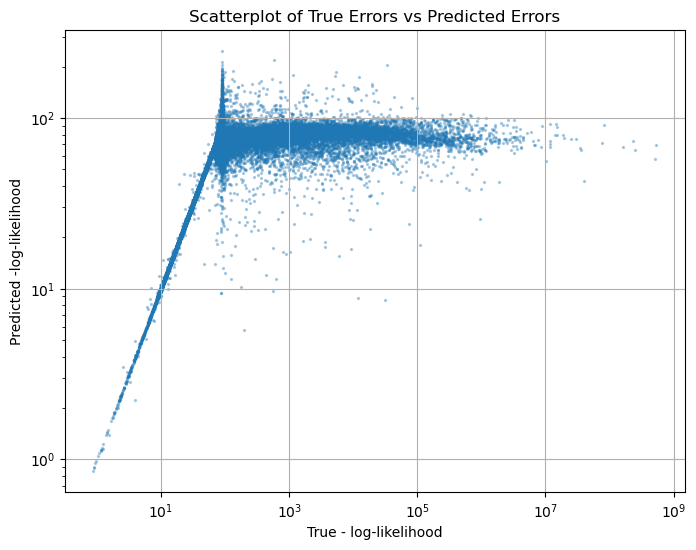

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(-errors_true, -errors_predicted, alpha=0.3, s=2)
plt.xlabel('True - log-likelihood')
plt.ylabel('Predicted -log-likelihood')
plt.title('Scatterplot of True Errors vs Predicted Errors')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()